## 심부전 & 나이 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr


In [4]:
df = pd.read_csv("C:/Users/nva_kist/Desktop/minsun/KIST/BioMarker/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


binary한 column 삭제

In [5]:
df_1 = df.drop(columns=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'time', 'DEATH_EVENT'])

In [6]:
df_1.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
0,75.0,582,20,265000.00,1.9,130
1,55.0,7861,38,263358.03,1.1,136
2,65.0,146,20,162000.00,1.3,129
3,50.0,111,20,210000.00,1.9,137
4,65.0,160,20,327000.00,2.7,116


In [7]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   creatinine_phosphokinase  299 non-null    int64  
 2   ejection_fraction         299 non-null    int64  
 3   platelets                 299 non-null    float64
 4   serum_creatinine          299 non-null    float64
 5   serum_sodium              299 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 14.1 KB


데이터 정제

In [8]:
df_1.isnull().sum()

age                         0
creatinine_phosphokinase    0
ejection_fraction           0
platelets                   0
serum_creatinine            0
serum_sodium                0
dtype: int64

<Axes: >

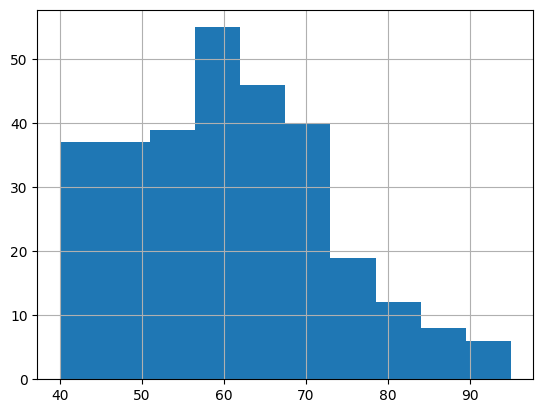

In [33]:
df_1['age'].hist(bins=10)

### Correlation analysis

In [10]:
corr = df_1.corr(method='pearson')['age'].sort_values(ascending=False)
print(corr)

age                         1.000000
serum_creatinine            0.159187
ejection_fraction           0.060098
serum_sodium               -0.045966
platelets                  -0.052354
creatinine_phosphokinase   -0.081584
Name: age, dtype: float64


### Partial Least Square Regression

X변수로 Y(age)를 잘 설명하는 선형결합을 찾는 과정, 공분산을 최대화하는 것과 더불어 correlation을 최대하는 방식

In [11]:
X = df_1[['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']]
y = df_1['age']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

pls = PLSRegression(n_components=1)
pls.fit(X_scaled, y_scaled)

,"n_components n_components: int, default=2Number of components to keep. Should be in `[1, n_features]`.",1
,"scale scale: bool, default=TrueWhether to scale `X` and `y`.",True
,"max_iter max_iter: int, default=500The maximum number of iterations of the power method when`algorithm='nipals'`. Ignored otherwise.",500
,"tol tol: float, default=1e-06The tolerance used as convergence criteria in the power method: thealgorithm stops whenever the squared norm of `u_i - u_{i-1}` is lessthan `tol`, where `u` corresponds to the left singular vector.",1e-06
,"copy copy: bool, default=TrueWhether to copy `X` and `y` in :term:`fit` before applying centering,and potentially scaling. If `False`, these operations will be doneinplace, modifying both arrays.",True


In [ ]:
X_score = pls.x_scores_
pls.x_loadings_

array([[-0.41457438],
       [ 0.22827301],
       [-0.27113989],
       [ 0.77881945],
       [-0.33584025]])

In [ ]:
# permutation test

def pls_statistic(X_scaled, y_scaled):
    pls = PLSRegression(n_components=1)
    T = pls.fit_transform(X_scaled, y_scaled)[0]
    return pearsonr(T[:,0], y_scaled[:,0])[0]

r_obs = pls_statistic(X_scaled, y_scaled)

B = 5000
rng = np.random.default_rng(0)
r_perm = []

for _ in range(B):
    idx = rng.permutation(len(y_scaled))
    r_perm.append(pls_statistic(X_scaled, y_scaled[idx]))

r_perm = np.array(r_perm)
p_perm = np.mean(np.abs(r_perm) >= np.abs(r_obs))

print("Observed corr:", r_obs)
print("Permutation p-value:", p_perm)


Observed corr: 0.1927054836152931
Permutation p-value: 0.044


결론: 연령과 관련된 잠재축에서 serum_creatinine, creatinine_phosphokinase로 영향이 큼 (절댓값이 큰 순)

### Canonical Correlation Analysis

X,Y 의 correlation이 최대가 되도록 선형결합을 찾는 분석

In [16]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)
U, V = cca.fit_transform(X_scaled, y_scaled)

In [29]:
r_can, p_can = pearsonr(U[:, 0], V[:, 0]) 
print(r_can, p_can)

0.19430985184526553 0.0007298547380315076


age와 5개 변수의 최적 선형결합 사이의 상관계수: 0.1943, p-value <0.05

In [31]:
Y_cols = ['creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium']

wY = pd.Series(cca.y_weights_[:, 0], index=Y_cols).sort_values(key=np.abs, ascending=False)
print(wY)


serum_creatinine            0.807014
creatinine_phosphokinase   -0.389663
ejection_fraction           0.347486
platelets                  -0.251948
serum_sodium               -0.112547
dtype: float64


결과: serum_creatinine의 절댓값이 가장 나이와 상관관계가 높음

## 알츠하이머 & 유전자

In [2]:
df1 = pd.read_csv("C:/Users/nva_kist/Desktop/minsun/KIST/BioMarker/bioAge.csv")
df2 = pd.read_csv("C:/Users/nva_kist/Desktop/minsun/KIST/BioMarker/genExp.csv")

In [5]:
df = pd.merge(df1,df2,on="colID",how="inner")

In [6]:
df.head()

,colID,bioAge,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_191,gene_192,gene_193,gene_194,gene_195,gene_196,gene_197,gene_198,gene_199,gene_200
0,1,36.851586,-0.164585,0.040658,0.051233,0.612458,0.814367,0.903788,0.790841,0.929245,...,1.527194,1.153498,0.983774,1.861407,1.584132,1.717259,1.328223,1.663326,1.447872,1.164417
1,2,60.798564,1.127400,0.784381,0.054773,-0.393805,-1.072067,-1.037722,-0.906722,-1.557458,...,-0.166757,0.776649,-0.016080,0.313827,0.374649,0.787964,0.704273,-0.343688,-0.968535,-0.490374
2,3,41.679575,0.445846,0.384656,1.288483,1.255949,0.719128,0.887472,0.412043,0.417071,...,0.905959,0.060796,-0.037192,-0.186945,-0.236791,-0.044534,0.431178,0.617813,0.407062,0.705926
3,4,40.497780,0.541814,0.509351,0.836148,0.768365,0.664751,0.756371,0.802373,0.307134,...,-0.136235,-0.746616,-0.650221,-0.391243,-0.450427,-0.267102,0.433445,0.517161,-0.189969,0.101876
4,5,60.996592,-0.185421,-0.745205,0.283565,0.461190,0.941849,0.853956,1.129381,1.274097,...,1.105922,0.053243,-0.373964,-0.281586,-0.434313,-0.838588,-0.229104,-0.605066,-0.555769,-0.553890


In [7]:
df.to_csv("C:/Users/nva_kist/Desktop/minsun/KIST/BioMarker/merged.csv", index=False)

### Sparse CCA

In [6]:
from numpy.linalg import svd
from statsmodels.multivariate.cancorr import CanCorr

from sparsecca import pmd

In [ ]:
path = "C:/Users/nva_kist/Desktop/minsun/KIST/BioMarker/merged.csv"
df = pd.read_csv(path)
df = df.dropna()

X = df[['gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5', 'gene_6', 'gene_7', 'gene_8', 'gene_9', 'gene_10', ]]
Z = df[['gene_11', 'gene_12', 'gene_13', 'gene_14', 'gene_15', 'gene_16', 'gene_17', 'gene_18', 'gene_19', 'gene_20']]

X = ((X - X.mean(axis=0)) / (X.std(axis=0) + 1e-12)).to_numpy()
Z = ((Z - Z.mean(axis=0)) / (Z.std(axis=0) + 1e-12)).to_numpy()


C:\Users\nva_kist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\_core\fromnumeric.py:4026: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [8]:
def print_weights(name, weights):
    first = weights[:, 0] / np.max(np.abs(weights[:, 0]))
    print(name + ': ' + ', '.join(['{:.3f}'.format(item) for item in first]))

In [21]:
U, V, D = pmd(X.T @ Z, K=2, penaltyu=0.5, penaltyv=0.5, standardize=False)

x_weights = U[:, 0]
z_weights = V[:, 0]
corrcoef = np.corrcoef(np.dot(x_weights, X.T), np.dot(z_weights, Z.T))[0, 1]
print("Corrcoef for comp 1: " + str(corrcoef))

print_weights('X', U)
print_weights('Z', V)

Corrcoef for comp 1: 0.14621664953324498
X: -0.000, -0.268, -0.871, -0.000, -1.000, -0.000, -0.000, -0.000, -0.000, 0.000
Z: 0.000, 0.000, 0.000, 0.522, 0.000, 0.003, 1.000, 0.121, 0.107, 0.051


In [18]:
wx = U[:,0]
print("min/max:", wx.min(), wx.max())
print("exact zeros:", (wx == 0).sum())
print("very small (<1e-12):", (abs(wx) < 1e-12).sum())

min/max: -0.7496312888448137 0.0
exact zeros: 7
very small (<1e-12): 7


### Partial correlation analysis

In [ ]:
import seaborn as sns
import pingouin as pg

In [14]:
df = pd.read_csv("C:/Users/nva_kist/Desktop/minsun/KIST/BioMarker/merged.csv")
print(df.head())
pg.partial_corr(data=df, x='bioAge', y='gene_1', covar=['gene_2', 'gene_3'])

   colID     bioAge    gene_1    gene_2    gene_3    gene_4    gene_5  \
0      1  36.851586 -0.164585  0.040658  0.051233  0.612458  0.814367   
1      2  60.798564  1.127400  0.784381  0.054773 -0.393805 -1.072067   
2      3  41.679575  0.445846  0.384656  1.288483  1.255949  0.719128   
3      4  40.497780  0.541814  0.509351  0.836148  0.768365  0.664751   
4      5  60.996592 -0.185421 -0.745205  0.283565  0.461190  0.941849   

     gene_6    gene_7    gene_8  ...  gene_191  gene_192  gene_193  gene_194  \
0  0.903788  0.790841  0.929245  ...  1.527194  1.153498  0.983774  1.861407   
1 -1.037722 -0.906722 -1.557458  ... -0.166757  0.776649 -0.016080  0.313827   
2  0.887472  0.412043  0.417071  ...  0.905959  0.060796 -0.037192 -0.186945   
3  0.756371  0.802373  0.307134  ... -0.136235 -0.746616 -0.650221 -0.391243   
4  0.853956  1.129381  1.274097  ...  1.105922  0.053243 -0.373964 -0.281586   

   gene_195  gene_196  gene_197  gene_198  gene_199  gene_200  
0  1.584132  1.7

,n,r,CI95%,p-val
pearson,300,0.085777,"[-0.03, 0.2]",0.13961


### After CCA